## Analyze whether SNWD varies more from year to year or from place to place.

In [1]:
import pandas as pd
import numpy as np
import urllib
import math
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets



Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.1+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [4]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBSSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
# df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
499


In [5]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'coeff_4', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_4', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [6]:
#extract longitude and latitude for each station
feature='coeff_4'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_4'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_4 FROM weather


,station,year,coeff_4
0,USC00420086,1941.0,-294.429859
1,USC00420900,1994.0,9.273887
2,USC00420900,1999.0,-1366.051667
3,USC00420900,1992.0,791.310816
4,USC00421008,2005.0,165.441055


In [7]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_4')
print year_station_table.shape
year_station_table.head(10)

(83, 39)


station,USC00260099,USC00261358,USC00266252,USC00420086,USC00420738,USC00420757,USC00420788,USC00420849,USC00420900,USC00421006,...,USC00426534,USC00426601,USC00426686,USC00428456,USC00428847,USC00429136,USC00429514,USW00023159,USW00023177,USW00093129
year,,,,,,,,,,,,,,,,,,,,,
1917.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929.0,NaN,NaN,NaN,216.030543,140.345989,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1930.0,NaN,NaN,NaN,290.746175,NaN,NaN,NaN,NaN,NaN,NaN,...,314.962792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1931.0,NaN,NaN,NaN,-547.935465,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1932.0,NaN,-138.688984,NaN,-140.846022,260.506303,NaN,-81.006108,NaN,NaN,NaN,...,187.681016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,NaN,198.024860,NaN,58.534323,461.626516,NaN,281.696594,NaN,NaN,NaN,...,188.892524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1935.0,NaN,NaN,NaN,33.972011,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1936.0,NaN,NaN,NaN,-516.492077,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the first eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

total RMS                   =  406484.224009
RMS removing mean-by-station=  344546.792077
Station fraction=  0.152373519742
RMS removing mean-by-year   =  242599.545515
Year fraction=  0.403175987687


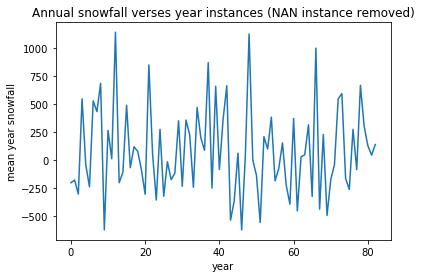

In [8]:
def RMS(Mat):
#     return np.sqrt(np.nanmean(Mat**2))
    return nanmean(Mat**2)


mean_by_year=np.nanmean(year_station_table,axis=1)
plot(-mean_by_year);
xlabel('year')
ylabel('mean year snowfall')
title('Annual snowfall verses year instances (NAN instance removed)')


mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station
baseMS = RMS(year_station_table)
stationMS = RMS(tbl_minus_station)
yearMS = RMS(tbl_minus_year)
print 'total RMS                   = ',baseMS
print 'RMS removing mean-by-station= ',stationMS
print 'Station fraction= ', (baseMS - stationMS)/baseMS
print 'RMS removing mean-by-year   = ',yearMS
print 'Year fraction= ', (baseMS - yearMS)/baseMS

In [31]:
T=year_station_table
print 'initial RMS=',RMS(T)
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)

initial RMS= 3018.17985113
0 after removing mean by year    = 2490.55574671
0 after removing mean by stations= 1590.1668932
1 after removing mean by year    = 1210.80580791
1 after removing mean by stations= 1059.43030299
2 after removing mean by year    = 1003.21780873
2 after removing mean by stations= 983.015629598
3 after removing mean by year    = 975.788123669
3 after removing mean by stations= 973.181257614
4 after removing mean by year    = 972.227812698
4 after removing mean by stations= 971.872720996
